## Recommender System using Spark and PySpark

This project demonstrate building recommender system using Spark
Two methods are demonstrated for recommendation
- Using Spark ALS matrix factorization
- Manually Coded User Collaboration using map reduce framework

In [1]:
#Load pyspark
import findspark
import os
findspark.init("/root/spark")

import pyspark
sc = pyspark.SparkContext()

The above code enables spark on this notebook and loads pyspark

In [2]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

Load Spark Session

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession\
        .builder\
        .appName("ALSExample")\
        .getOrCreate()

### Read File
Read file from Haddop, parse the file and map fields to correct format

In [4]:
file_data = spark.read.text("/u.data").rdd


In [5]:
rating = file_data.map(lambda row: row.value.split("\t"))

Let's define a function to make printing rdd and dataframe head (that is to see top rows)

In [6]:
def print_head(data,n=5):
    for row in data.take(n):
        print row
    

In [7]:
print_head(rating)

[u'196', u'242', u'3', u'881250949']
[u'186', u'302', u'3', u'891717742']
[u'22', u'377', u'1', u'878887116']
[u'244', u'51', u'2', u'880606923']
[u'166', u'346', u'1', u'886397596']


In [8]:
ratingsRDD = rating.map(lambda p: Row(userId=int(p[0]), movieId=int(p[1]),
                                     rating=float(p[2])))



In [9]:
print_head(ratingsRDD)

Row(movieId=242, rating=3.0, userId=196)
Row(movieId=302, rating=3.0, userId=186)
Row(movieId=377, rating=1.0, userId=22)
Row(movieId=51, rating=2.0, userId=244)
Row(movieId=346, rating=1.0, userId=166)


In [10]:
ratingsRDD.count()

100000

### Rating Distribution

In [11]:
rate_count=ratingsRDD.map(lambda x: (x.rating,1)).countByKey()

In [12]:
print rate_count

defaultdict(<type 'int'>, {1.0: 6110, 2.0: 11370, 3.0: 27145, 4.0: 34174, 5.0: 21201})


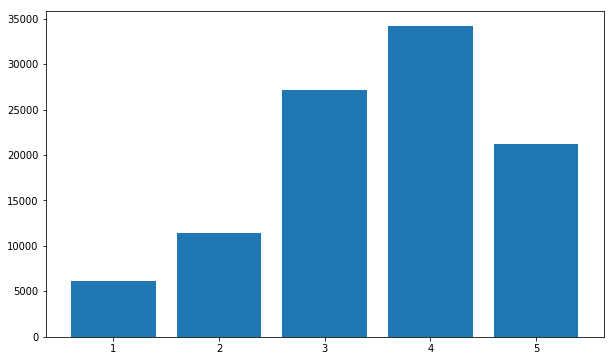

In [13]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
plt.figure()
plt.bar(rate_count.keys(),rate_count.values())
plt.show()

### User Rating Frequency

In [14]:
usr_rate_count=ratingsRDD.map(lambda x: (x.userId,1)).countByKey()
#count_freq=.map(lambda x:x[1]).countByKey()

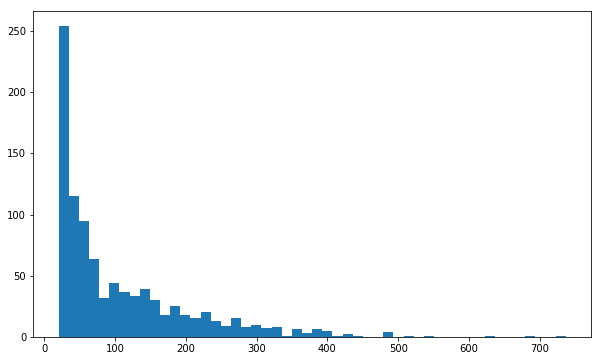

In [15]:

plt.hist(usr_rate_count.values(),50)
plt.show()

Let's keep users who have provided 21 or more ratings

In [16]:
usr_nrating=sc.broadcast(usr_rate_count)

In [17]:
ratingsRDD=ratingsRDD.filter(lambda x: usr_nrating.value[x.userId] > 20)

In [18]:
ratingsRDD.count()

99360

Split dataset by training and testing

In [19]:
ratings_df = spark.createDataFrame(ratingsRDD)
(training, test) = ratings_df.randomSplit([0.8, 0.2])

Build alternate least square model

In [20]:
als = ALS(maxIter=5, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating")
model = als.fit(training)

In [21]:
pred = model.transform(test)

In [22]:
pred1=pred.dropna()
pred1=pred1.orderBy(pred.prediction.desc())

In [23]:
rmse_eval = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = rmse_eval.evaluate(pred1)
print rmse

1.06149221554


The RMSE is reasonable given that we used raw scores. 

In [24]:
print_head(pred.filter("userId==121"))

Row(movieId=458, rating=1.0, userId=121, prediction=1.999855637550354)
Row(movieId=192, rating=4.0, userId=121, prediction=3.8486106395721436)
Row(movieId=57, rating=5.0, userId=121, prediction=5.027899742126465)
Row(movieId=117, rating=1.0, userId=121, prediction=3.138828992843628)
Row(movieId=1194, rating=4.0, userId=121, prediction=3.686807632446289)


## User Based Collabrative Filtering

Let's combine user rating by userid so that we could process the ratings for the user

In [19]:
def dict_update(x,y):
    x.update(y)
    return x
rating_byuser=ratingsRDD.map(lambda x:(x.userId,({x.movieId:x.rating}))).\
aggregateByKey({},lambda x,y:dict_update(x,y),lambda x,y:dict_update(x,y))

The ratings are converted to (User, rating-dictionary) format

In [20]:
print_head(rating_byuser,1)

(1, {1: 5.0, 2: 3.0, 3: 4.0, 4: 3.0, 5: 3.0, 6: 5.0, 7: 4.0, 8: 1.0, 9: 5.0, 10: 3.0, 11: 2.0, 12: 5.0, 13: 5.0, 14: 5.0, 15: 5.0, 16: 5.0, 17: 3.0, 18: 4.0, 19: 5.0, 20: 4.0, 21: 1.0, 22: 4.0, 23: 4.0, 24: 3.0, 25: 4.0, 26: 3.0, 27: 2.0, 28: 4.0, 29: 1.0, 30: 3.0, 31: 3.0, 32: 5.0, 33: 4.0, 34: 2.0, 35: 1.0, 36: 2.0, 37: 2.0, 38: 3.0, 39: 4.0, 40: 3.0, 41: 2.0, 42: 5.0, 43: 4.0, 44: 5.0, 45: 5.0, 46: 4.0, 47: 4.0, 48: 5.0, 49: 3.0, 50: 5.0, 51: 4.0, 52: 4.0, 53: 3.0, 54: 3.0, 55: 5.0, 56: 4.0, 57: 5.0, 58: 4.0, 59: 5.0, 60: 5.0, 61: 4.0, 62: 3.0, 63: 2.0, 64: 5.0, 65: 4.0, 66: 4.0, 67: 3.0, 68: 4.0, 69: 3.0, 70: 3.0, 71: 3.0, 72: 4.0, 73: 3.0, 74: 1.0, 75: 4.0, 76: 4.0, 77: 4.0, 78: 1.0, 79: 4.0, 80: 4.0, 81: 5.0, 82: 5.0, 83: 3.0, 84: 4.0, 85: 3.0, 86: 5.0, 87: 5.0, 88: 4.0, 89: 5.0, 90: 4.0, 91: 5.0, 92: 3.0, 93: 5.0, 94: 2.0, 95: 4.0, 96: 5.0, 97: 3.0, 98: 4.0, 99: 3.0, 100: 5.0, 101: 2.0, 102: 2.0, 103: 1.0, 104: 1.0, 105: 2.0, 106: 4.0, 107: 4.0, 108: 5.0, 109: 5.0, 110: 1.0, 111

#### User Pair
In order to compute user similarity we need to compare users. As we will be using long format we do this by pairing up a user with all other users.

In [21]:
user_pair=rating_byuser.cartesian(rating_byuser).filter(lambda x: x[0][0]!=x[1][0])

In [22]:
print_head(user_pair,1)

((1, {1: 5.0, 2: 3.0, 3: 4.0, 4: 3.0, 5: 3.0, 6: 5.0, 7: 4.0, 8: 1.0, 9: 5.0, 10: 3.0, 11: 2.0, 12: 5.0, 13: 5.0, 14: 5.0, 15: 5.0, 16: 5.0, 17: 3.0, 18: 4.0, 19: 5.0, 20: 4.0, 21: 1.0, 22: 4.0, 23: 4.0, 24: 3.0, 25: 4.0, 26: 3.0, 27: 2.0, 28: 4.0, 29: 1.0, 30: 3.0, 31: 3.0, 32: 5.0, 33: 4.0, 34: 2.0, 35: 1.0, 36: 2.0, 37: 2.0, 38: 3.0, 39: 4.0, 40: 3.0, 41: 2.0, 42: 5.0, 43: 4.0, 44: 5.0, 45: 5.0, 46: 4.0, 47: 4.0, 48: 5.0, 49: 3.0, 50: 5.0, 51: 4.0, 52: 4.0, 53: 3.0, 54: 3.0, 55: 5.0, 56: 4.0, 57: 5.0, 58: 4.0, 59: 5.0, 60: 5.0, 61: 4.0, 62: 3.0, 63: 2.0, 64: 5.0, 65: 4.0, 66: 4.0, 67: 3.0, 68: 4.0, 69: 3.0, 70: 3.0, 71: 3.0, 72: 4.0, 73: 3.0, 74: 1.0, 75: 4.0, 76: 4.0, 77: 4.0, 78: 1.0, 79: 4.0, 80: 4.0, 81: 5.0, 82: 5.0, 83: 3.0, 84: 4.0, 85: 3.0, 86: 5.0, 87: 5.0, 88: 4.0, 89: 5.0, 90: 4.0, 91: 5.0, 92: 3.0, 93: 5.0, 94: 2.0, 95: 4.0, 96: 5.0, 97: 3.0, 98: 4.0, 99: 3.0, 100: 5.0, 101: 2.0, 102: 2.0, 103: 1.0, 104: 1.0, 105: 2.0, 106: 4.0, 107: 4.0, 108: 5.0, 109: 5.0, 110: 1.0, 11

### Function to compute user similarity (using pearson coefficient)

            

In [24]:
def user_similarity(x):
    user1=x[0][0]
    user2=x[1][0]
    rating1=x[0][1]
    rating2=x[1][1]
    x1=[]
    x2=[]
    for key in rating1.keys():
        if key in rating2.keys():
            x1 = x1 + [rating1[key]]
            x2 = x2 + [rating2[key]]
    corr=0
    if len(x1) > 3:
        x1_mean=sum(x1)/len(x1)
        x2_mean=sum(x2)/len(x2)
        x1_cent=[ax - x1_mean for ax in x1]
        x2_cent=[ax - x2_mean for ax in x2]
        x_sum=sum([ax*ay for ax,ay in zip(x1_cent,x2_cent)])
        x1_sqsum=sum([ax**2 for ax in x1_cent])**0.5
        x2_sqsum=sum([ax**2 for ax in x2_cent])**0.5
        sqsum_prod = x1_sqsum*x2_sqsum
        if sqsum_prod !=0:
            corr=x_sum/(x1_sqsum*x2_sqsum)
    return (x[0],x[1],corr)

In [26]:
user_pair_sim=user_pair.map(user_similarity)

In [27]:
print_head(user_pair_sim,1)

((1, {1: 5.0, 2: 3.0, 3: 4.0, 4: 3.0, 5: 3.0, 6: 5.0, 7: 4.0, 8: 1.0, 9: 5.0, 10: 3.0, 11: 2.0, 12: 5.0, 13: 5.0, 14: 5.0, 15: 5.0, 16: 5.0, 17: 3.0, 18: 4.0, 19: 5.0, 20: 4.0, 21: 1.0, 22: 4.0, 23: 4.0, 24: 3.0, 25: 4.0, 26: 3.0, 27: 2.0, 28: 4.0, 29: 1.0, 30: 3.0, 31: 3.0, 32: 5.0, 33: 4.0, 34: 2.0, 35: 1.0, 36: 2.0, 37: 2.0, 38: 3.0, 39: 4.0, 40: 3.0, 41: 2.0, 42: 5.0, 43: 4.0, 44: 5.0, 45: 5.0, 46: 4.0, 47: 4.0, 48: 5.0, 49: 3.0, 50: 5.0, 51: 4.0, 52: 4.0, 53: 3.0, 54: 3.0, 55: 5.0, 56: 4.0, 57: 5.0, 58: 4.0, 59: 5.0, 60: 5.0, 61: 4.0, 62: 3.0, 63: 2.0, 64: 5.0, 65: 4.0, 66: 4.0, 67: 3.0, 68: 4.0, 69: 3.0, 70: 3.0, 71: 3.0, 72: 4.0, 73: 3.0, 74: 1.0, 75: 4.0, 76: 4.0, 77: 4.0, 78: 1.0, 79: 4.0, 80: 4.0, 81: 5.0, 82: 5.0, 83: 3.0, 84: 4.0, 85: 3.0, 86: 5.0, 87: 5.0, 88: 4.0, 89: 5.0, 90: 4.0, 91: 5.0, 92: 3.0, 93: 5.0, 94: 2.0, 95: 4.0, 96: 5.0, 97: 3.0, 98: 4.0, 99: 3.0, 100: 5.0, 101: 2.0, 102: 2.0, 103: 1.0, 104: 1.0, 105: 2.0, 106: 4.0, 107: 4.0, 108: 5.0, 109: 5.0, 110: 1.0, 11

Let's define a function to compute collaborative rating score

In [28]:
def user_collab_rating(x):
    user2_rating=x[1][1]
    corr=x[2]
    for key in user2_rating:
        if (corr!=0):
            user2_rating[key]=corr*user2_rating[key]
        else:
            user2_rating[key]=0
    return(x[0][0],user2_rating)


#### Function to reduce two dictionary by adding the values 

In [30]:
def add_dict(a,b):
    return dict(a.items() + b.items() + [(k, a[k] + b[k]) for k in set(b) & set(a)])

Function to get Recommendation for user from every other user

In [34]:
def get_recommend(uid,user_sim):
    reco=user_sim.filter(lambda x:x[0][0]==uid).map(user_collab_rating)
    return reco
    

In [35]:
reco=get_recommend(1,user_pair_sim)

In [36]:
print_head(reco,2)

(1, {257: 0.643364931417479, 258: 0.4825236985631092, 1: 0.643364931417479, 10: 0.3216824657087395, 13: 0.643364931417479, 14: 0.643364931417479, 272: 0.8042061642718488, 273: 0.643364931417479, 274: 0.4825236985631092, 19: 0.4825236985631092, 276: 0.643364931417479, 277: 0.643364931417479, 278: 0.4825236985631092, 279: 0.643364931417479, 280: 0.4825236985631092, 25: 0.643364931417479, 282: 0.643364931417479, 283: 0.8042061642718488, 284: 0.643364931417479, 285: 0.8042061642718488, 286: 0.643364931417479, 287: 0.4825236985631092, 288: 0.4825236985631092, 289: 0.4825236985631092, 290: 0.4825236985631092, 291: 0.4825236985631092, 292: 0.643364931417479, 293: 0.643364931417479, 294: 0.16084123285436974, 295: 0.643364931417479, 296: 0.4825236985631092, 297: 0.643364931417479, 298: 0.4825236985631092, 299: 0.643364931417479, 300: 0.643364931417479, 301: 0.643364931417479, 302: 0.8042061642718488, 303: 0.643364931417479, 304: 0.643364931417479, 305: 0.4825236985631092, 306: 0.643364931417479

Add up recommendation score from other users (based on similarity) to get raw score

In [37]:
reco1=reco.reduce(lambda x,y:(x[0],add_dict(x[1],y[1])))

In [44]:
#Scores for all movies for the user
reco1[1]

{1: 395.73213758246504,
 2: 112.4919134765162,
 3: 66.18780988967809,
 4: 186.06872052327213,
 5: 63.524287368140556,
 6: 16.13588201467643,
 7: 358.4328050389879,
 8: 173.21467050823784,
 9: 275.2702036950891,
 10: 74.02457616122459,
 11: 214.3278281000142,
 12: 274.9804498181234,
 13: 149.05826492485977,
 14: 155.0499718205854,
 15: 244.37966356787427,
 16: 26.84556514097724,
 17: 76.77054007677489,
 18: 3.333664850464438,
 19: 53.34559222335186,
 20: 63.091162705263145,
 21: 61.273650553594955,
 22: 278.8055921790232,
 23: 163.36223580386252,
 24: 155.95033047254196,
 25: 230.05467128084305,
 26: 53.47032191352984,
 27: 47.67194459308018,
 28: 244.61621023395534,
 29: 76.501258570994,
 30: 27.109001448309648,
 31: 130.69148549262215,
 32: 65.70758322167922,
 33: 85.72951342544935,
 34: 3.1451002459150983,
 35: 2.7168476330190474,
 36: 4.37609147976698,
 37: 4.646513149045008,
 38: 85.23635161681388,
 39: 69.08167186837875,
 40: 34.09090458714776,
 41: 24.308564315090653,
 42: 137.65

Get top recommendation by sorting the movie by the raw score and taking top 10 rows.

In [42]:
top_rec=[y for x,y in sorted(zip(reco1[1].values(),reco1[1].keys()),reverse=True)][0:10]

In [43]:
top_rec

[50, 181, 100, 258, 127, 174, 1, 286, 172, 7]

### Summary

Using spark and pyspark a scalable recommender system is built and implemented on AWS EC2 cluster. 